This is a very simple notebook that loads in recordings of 100 photosensor-only trials in order to compute the average delay between an LSL marker and stimulus onset. We can use these delays for each subject, since it seems to be monitor-specific, to account for the delay and produce ERPs locked to a more correct time.
<br><br>
Given the jitter in this being within 1 frame to +/- 1 frame, I think using a generic correction will be fine. Due to the error in the OpenBCI Analog and/or LSL widget, the sampling rate of the photosensor is significantly lower than what the EEG would be. This means that even if we were to record EEG + Photosensor on every trial, this stack would not be sufficient to correct the data accurately, although it would still be accurate to the frame level since our monitors were only 60 Hz (despite the raw XDF files incorrectly stating they were 165, which is my bad)

In [1]:
import ezbci as ez
import numpy as np
import matplotlib.pyplot as plt
import pyxdf

Effective srate: 59.26960673915415
Effective srate: 59.829267498563084
Effective srate: 59.874130321455844


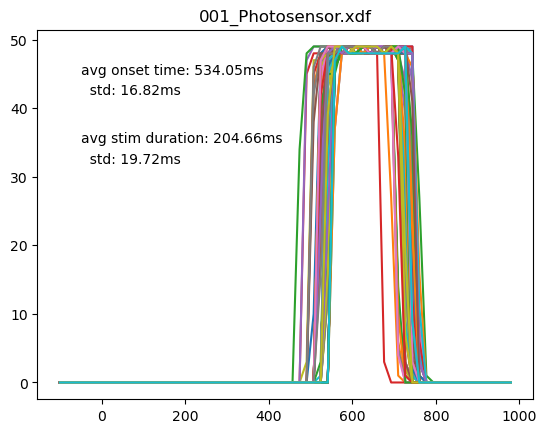

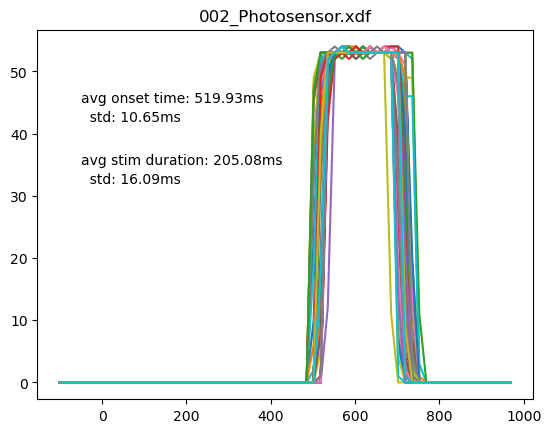

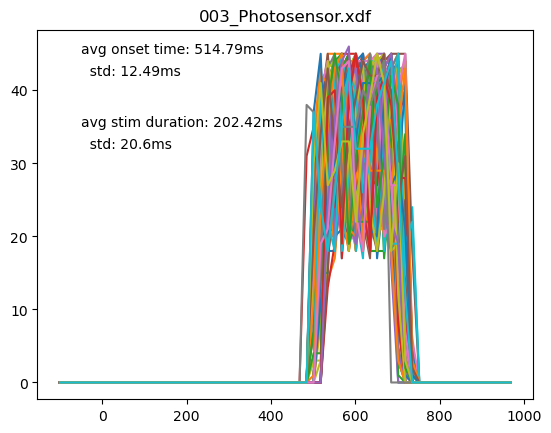

In [2]:
data_dir = '../data/Photosensor/'

for i in range(1, 4):
    # Load data
    fname = f'00{i}_Photosensor.xdf'
    raw = ez.loadxdf(f'{data_dir}{fname}', False)

    # Note that the sampling rate is NOT 250 Hz due to a bug with OpenBCI GUI
    # (this bug should have been fixed in ~2020 but apparently has not)
    effective_srate = 1/np.mean(raw["eeg_time"][1:] - raw["eeg_time"][0:-1])
    print(f'Effective srate: {effective_srate}')
    raw['fs'] = effective_srate

    # Once sampling rate has been corrected, epoch the data
    epoch = ez.epoch(raw, -100, 1000, -100, 100, '0', r'S_.*')

    # Plot all data and compute average/std
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor('white')
    onset_times = []
    stim_durations = []
    for i in range(epoch['bin_data'].shape[2]):
        # Find first place where non-zero:
        onset = np.where(epoch['bin_data'][0, :, i] != 0)[0][0]
        offset = np.where(epoch['bin_data'][0, :, i] != 0)[0][-1]
        onset_time = epoch['bin_times'][onset]
        offset_time = epoch['bin_times'][offset]
        onset_times.append(onset_time)
        stim_durations.append(offset_time - onset_time)
        plt.plot(epoch['bin_times'][:-1], epoch['bin_data'][0, :, i])

    # Compute stats, apply to plots
    plt.title(fname)
    avg_onset = np.mean(onset_times)
    std_onset = np.std(onset_times, ddof=1)
    avg_duration = np.mean(stim_durations)
    std_duration = np.std(stim_durations, ddof=1)
    plt.text(-50, 45, f'avg onset time: {round(avg_onset, 2)}ms')
    plt.text(-50, 42, f'  std: {round(std_onset, 2)}ms')
    plt.text(-50, 35, f'avg stim duration: {round(avg_duration, 2)}ms')
    plt.text(-50, 32, f'  std: {round(std_duration, 2)}ms')